## MOU

## Estimation
### Moments
### MMSE
### MLE
### Bayesian

## Multivariate Ornstein-Uhlenbeck

Dynamics of each node i in the network:
$ \frac{dx_i}{dt} = -\frac{x_i}{\tau_x} + \sum_{j\ne i}^M C_{ij} x_j + \mu_i + \sigma_i \frac{dB_i}{dt} $

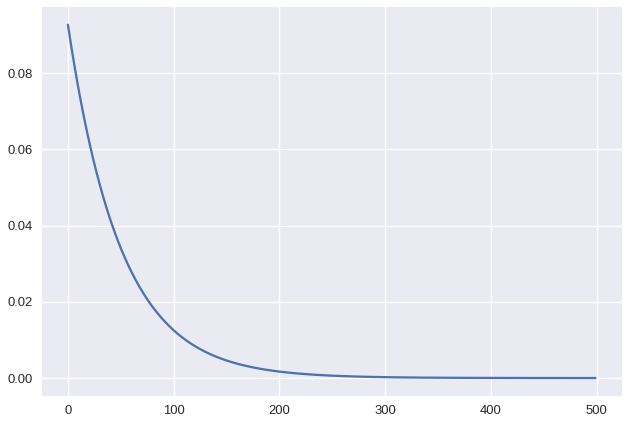

In [1]:
from MOU import MOU
from scipy.io import loadmat
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from make_rnd_connectivity import make_rnd_connectivity
import seaborn as sns

sns.set_context('talk')

model = MOU(n_nodes=1, tau_x=50, mu=0.0, Sigma=1e-18)
#model.C[0, 1] = 0.01
#model.C[1, 0] = 0.01
ts = model.simulate(T=500)
plt.figure()
plt.plot(ts)
plt.show()

### Create random connectivity matrix

$$ C' = A \otimes W $$
where $ A\sim Bern(p)$ and $ ln W \sim \mathcal{N}(0,1)$
When varying the number of nodes C' gets normalized in order to avoid explosion of activity.
$$ C = \frac{C' N}{\sum_{i,j} C'} $$

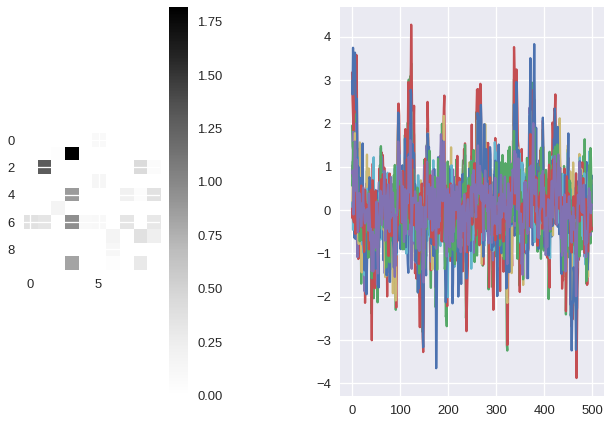

In [25]:
C = make_rnd_connectivity(N=10, density=0.2, connectivity_strength=1)
model = MOU(n_nodes=10, tau_x=1, mu=0.0, Sigma=None, C=C, random_state=5)
ts = model.simulate(T=500, random_state=0)
plt.figure()
plt.subplot(1,3,1)
plt.imshow(C)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(ts)
plt.show()

### Forward step
The Jacobian of the system is: $ J_{ij} = -\frac{\delta_{ij}}{\tau_x}C_{ij}$, where $\delta_{ij}$ is Kronecker's delta.
Deriving the covariance of the system we obtain the Lyapunov equation: $ JQ^0 + Q^0J^T + \Sigma = 0 $, where $\Sigma$ is the diagonal matrix $\Sigma_{ii} = \sigma_i$.
From this equation the vectorized covariance can be calculated as: 
$$ vec(Q^0) = -\frac{vec(\Sigma)}{I_M \otimes J + \tilde{J} \otimes I_M}$$
where $\tilde{A}$ indicates the matrix of complex conjugate elements of $A$.
Similarly the derivation of the time-lagged covariance for lag $\tau$ yealds:
$$ Q^{\tau} = Q^0 expm(J^T\tau)$$

These equations allow to compute the farward step: calculate (time-lagged) covariance matrix knowing the parameters of the system $\theta: \{C, \Sigma, \tau_x\}$.

### Parameter estimation
#### Moments method
In order to estimate the parameters $\theta$ we can apply the moments method.
We can use the empirical covariances $\hat{Q}^0$, $\hat{Q}^{\tau}$ and last equation to get:
$$ \hat{J} = \frac{1}{\tau} \Bigl[logm(\hat{Q}^{\tau}(\hat{Q}^0)^{-1})\Bigr]^{T}  $$
An estimate of $\Sigma$ can then be calculated from Lyapunov equation above:
$$ \hat{\Sigma} = -\hat{J}\hat{Q}^0 - \hat{Q}^0 \hat{J}^T $$

#### Natural Gradient Optimization:
Lyapunov function:
$$ V(C) = (Q^0-\hat{Q}^0)^2 + (Q^{\tau}-\hat{Q}^{\tau})^2 $$
$$ \Delta J = \frac{1}{\tau} \Bigl[(Q^0)^{-1} (\Delta Q^0 + \Delta Q^{\tau} expm(-J^T \tau)) \Bigr]^T$$
$$\Delta \Sigma_{ii} = \hat{Q}^0_{ii} - Q^0_{ii}$$

#### Bayesian approach
The probability of the state of the system at time $t'$ give its state at time $t$ is given by:
$$ x(t'|t) \sim \mathcal{N}\Bigl(expm(J\Delta t)x(t), \Xi \Bigr)$$
where $\Xi = Q^0 - expm(J\Delta t) Q^0 expm(J \Delta t)^T$ and $\Delta t = t'-t$.

The stationary distribution is: $x \sim \mathcal{N}(0, Q^0)$.

Given a dataset where x is sampled at regular intervals $x^1, x^2,\dots, x^N$, and $X$ is the $M$ times $N$ matrix collecting all the $N$ observations for each of the $M$ nodes, the likelihood function is given by:
$$p(X|\theta) = \prod_n^N p(x^{n+1} | x^n, \theta)p(x^1|\theta)$$
Then the posterior distribution of parameters is given by:
$$ p(\theta|X)=\frac{p(X|\theta)p(\theta)}{p(X)}$$
The log posterior substituting the explicit pdfs is:
$$ ln p(\theta|X) = -\frac{1}{2} \sum_n^N \Delta_n^T \Xi \Delta_n -\frac{1}{2} (x^1)^T (Q^0)^{-1} x^1 + \frac{N-1}{2} ln \frac{1}{(2\pi)^M |\Xi|} + \frac{1}{2} ln \frac{1}{(2\pi)^M |Q^0|} $$
where $\Delta_n = x^{n+1}+Jx^n$.
Taking the derivative of the log posterior and maximizing yields the MAP solution. Defining $T^0 = \sum^N x^n(x^n)^T $ and $T^1 = \sum^N x^{n+1}(x^n)^T $, the MAP solution for $\Lambda=exmp(J \Delta t)$ is:
$\hat{\Lambda} = T^1 (T^0)^{-1}$ ($\Xi$ can also be estimated with the same method).
It follows than that:
$$ \hat{J} = \frac{logm(\hat{\Lambda})}{\Delta t} $$
Sigma can then be estimated again from the Lyapunov equation:
$$ \hat{\Sigma} = -\hat{J}\hat{Q}^0 - \hat{Q}^0 \hat{J}^T $$

## Estimation accuracy varying N (with synthetic data)

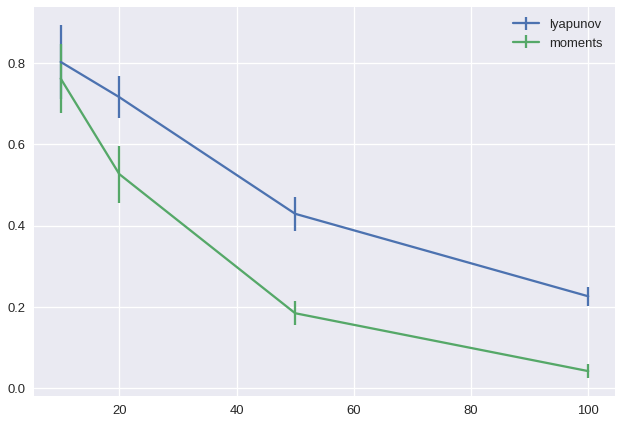

In [2]:
Ns = [10, 20, 50, 100]
repetitions = 100
file_name = "comparison_T500.npy"
file = np.load(file_name)
gen = file[0]
lyap = file[1]
mome = file[2]
rCl = np.zeros([len(Ns), repetitions])
rCm = np.zeros([len(Ns), repetitions])
for i, N in enumerate(Ns):
    for r in range(repetitions):
        rCl[i, r] = pearsonr(lyap[N][r].C.flatten(), gen[N][r].C.flatten())[0]
        rCm[i, r] = pearsonr(mome[N][r].C.flatten(), gen[N][r].C.flatten())[0]
plt.figure()
plt.errorbar(Ns, rCl.mean(axis=1), rCl.std(axis=1), label='lyapunov')
plt.errorbar(Ns, rCm.mean(axis=1), rCm.std(axis=1), label='moments')
plt.legend()
plt.show()

## Estimation accuracy varying T (fixed N)
estimate connectivity from data (possibly long timeseries)
simulate with MOU using estimated connectivity varying T
estimate C with MOU

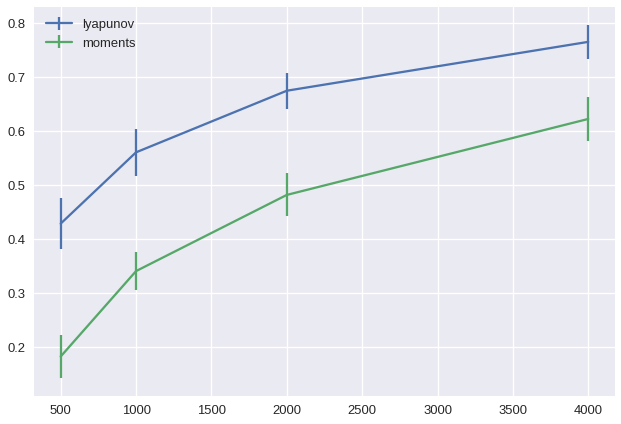

In [3]:
N = 50
Ts = [500, 1000, 2000, 4000]
repetitions = 100
file_name = "comparison_N50.npy"
file = np.load(file_name)
gen = file[0]
lyap = file[1]
mome = file[2]
rCl = np.zeros([len(Ts), repetitions])
rCm = np.zeros([len(Ts), repetitions])
for i, T in enumerate(Ts):
    for r in range(repetitions):
        rCl[i, r] = pearsonr(lyap[T][r].C.flatten(), gen[T][r].C.flatten())[0]
        rCm[i, r] = pearsonr(mome[T][r].C.flatten(), gen[T][r].C.flatten())[0]
plt.figure()
plt.errorbar(Ts, rCl.mean(axis=1), rCl.std(axis=1), label='lyapunov')
plt.errorbar(Ts, rCm.mean(axis=1), rCm.std(axis=1), label='moments')
plt.legend()
plt.show()

## Connectivity estimated from data

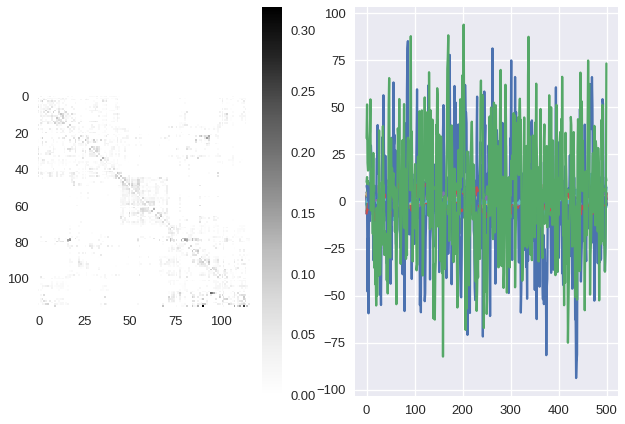

In [33]:
data = np.loadtxt('ROISignals_0025427_SE01.txt')
mask_AAL = np.array(loadmat('/home/andrea/Work/vicente/mask_EC_AAL.mat')['mask_EC'], dtype=bool)
model = MOU(n_nodes=116)
model.fit(X=data, SC_mask=mask_AAL)
Cemp = model.C
plt.figure()
plt.subplot(1,2,1)
plt.imshow(Cemp)
plt.colorbar()
plt.subplot(1,2,2)
plt.plot(model.simulate(T=500))
plt.show()

## Estimation varying T (with empirical connectivity)

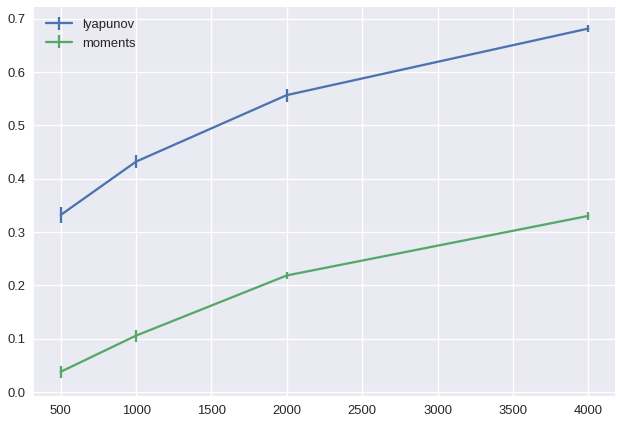

In [35]:
N = 116
Ts = [500, 1000, 2000, 4000]
repetitions = 10
file_name = "comparison_N116_empC.npy"
file = np.load(file_name)
gen = file[0]
lyap = file[1]
mome = file[2]
rCl = np.zeros([len(Ts), repetitions])
rCm = np.zeros([len(Ts), repetitions])
for i, T in enumerate(Ts):
    for r in range(repetitions):
        rCl[i, r] = pearsonr(lyap[T][r].C.flatten(), gen[T][r].C.flatten())[0]
        rCm[i, r] = pearsonr(mome[T][r].C.flatten(), gen[T][r].C.flatten())[0]
plt.figure()
plt.errorbar(Ts, rCl.mean(axis=1), rCl.std(axis=1), label='lyapunov')
plt.errorbar(Ts, rCm.mean(axis=1), rCm.std(axis=1), label='moments')
plt.legend()
plt.show()

## Estimation accuracy varying the strength of connections
use Gamma to sample the weight matrix and change the location parameter to change the strength of connections